Requirements


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import sddk

In [3]:
conf = sddk.configure("SDAM_root", "648597@au.dk")

sciencedata.dk username (format '123456@au.dk'): 648597@au.dk
sciencedata.dk password: ········
connection with shared folder established with you as its owner
endpoint variable has been configured to: https://sciencedata.dk/files/SDAM_root/


In [ ]:
# read the EDH dataset from sciencedata.dk
EDH = sddk.read_file("SDAM_data/EDH/EDH_cleaned_2020-06-26.json", "df", conf)

In [ ]:
def lists_to_values(list_or_value):
  if isinstance(list_or_value, list):
    value = list_or_value[0]
  else: 
    value = list_or_value
  return value
for column in EDH.columns:
  EDH[column] = EDH.apply(lambda row: lists_to_values(row[column]), axis=1)

In [ ]:
EDH.head(5)

In [18]:
#
EDH["not_after"] = pd.to_numeric(EDH["not_after"])
EDH["not_before"] = pd.to_numeric(EDH["not_before"])

In [19]:
### how many of the inscriptions have at least one date
EDH_dated = EDH[(EDH["not_before"].notnull()) | (EDH["not_after"].notnull())]
len(EDH_dated)

57782

In [20]:
len(EDH_dated[EDH_dated["not_after"].isnull()])

3457

In [ ]:
EDH_dated["randoms"] = EDH_dated.apply(lambda row: model_date(row["not_before"], row["not_after"]), axis=1)

# Define function  "dist_range()"

In [30]:
def dist_range(start, stop, size=1, b=0.1): # this function has been implemented into already modelling_distributions.py
  """
  get random numbers of size size ib on the basis of start date and end date and trapezoid distribution defined by first turn point (lower bound)
  """
  r = trapz.rvs(b, 1-b, size=size)
  duration = abs((start)-stop)
  if duration == 0:
    random_values = [start] * size
    return random_values
  else:
    random_values = list(((r * duration) + start).round().astype(int))
    if size == 1: # if only one number, return it as a number
      return random_values[0]
    else: # otherwise return a list of values
      return random_values

# Define function "dist_ante_post()"

In [24]:
def dist_ante_post(date, date_type, size=1, duration=100):
  """
  get random numbers of size size ib on the basis of start date and end date and trapezoid distribution defined by first turn point (lower bound)
  """
  if "post" in date_type:
    r = trapz.rvs(0, 0.50, size=size)
    return ((r * duration) + date).astype(int)
  if "ante" in date_type:
    r = trapz.rvs(0.50, 1, size=size)
    return ((r * duration) + date).astype(int)

# Define function "model_date()"

In [26]:
def model_date(start, stop, size=1, scale=50, b=0.1):
    """
    combine dist_range() and dist_ante_post()
    """
    try:
      randoms = dist_range(int(start), int(stop), size=size, b=b)
    except:
      try:
        randoms =  dist_ante_post(int(start), "post", size=size, scale=scale)
      except:
        try:
          randoms =  dist_ante_post(int(stop), "ante", size=size, scale=scale)
        except:
          randoms = None
    return randoms

In [32]:
EDH_dated["randoms"] = EDH_dated.apply(lambda row: model_date(row["not_before"], row["not_after"]), axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [33]:
EDH_condensed = EDH_dated[["id", "not_before", "not_after", "randoms"]]
EDH_condensed.head(20)

,id,not_before,not_after,randoms
0,HD000001,71.0,130.0,None
1,HD000002,51.0,200.0,None
2,HD000003,131.0,170.0,None
3,HD000004,151.0,200.0,None
4,HD000005,1.0,200.0,None
5,HD000006,71.0,150.0,None
6,HD000007,-100.0,-51.0,None
7,HD000008,101.0,200.0,None
8,HD000009,201.0,300.0,None
9,HD000010,101.0,200.0,None


In [16]:
def get_number(row, n):
  try:
    return row["randoms"][n]
  except:
    return None

step = 25
bin_ranges=[n for n in range(-100, 400 + step, step)]
for n in range(len(EDH_dated.iloc[0]["randoms"])): # for each number in lenght of our random numbers
  dates_variant = EDH_dated.apply(lambda row: get_number(row, n), axis=1)
  plt.hist(dates_variant, bins=bin_ranges, histtype='step', stacked=True, fill=False)
  plt.xlim(-100, 400)

TypeError: ignored

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


(-100.0, 400.0)

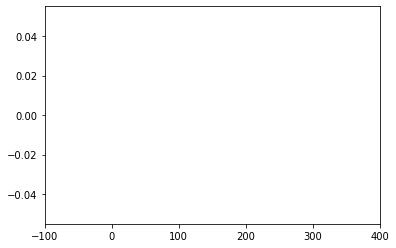

In [17]:
for n in range(100):
  dates_variant = EDH_condensed.apply(lambda row: get_number(row, n), axis=1)
  sns.distplot(dates_variant, hist=False)
plt.xlim(-100, 400)